accuracy만으로 평가했을 때의 성능 왜곡 가능성을 알아보기 위해  
남자->죽 여자->생존 의 단순 알고리즘 결과 알아보겠다

In [1]:
from sklearn.base import BaseEstimator

In [2]:
class MyDummyClassifier(BaseEstimator):
    #fit()메소드는 아무것도 학습하지 않는다
    def fit(self, X, y=None):
        pass
    #predict()메소드는 단순히 sex=1이면 0 그렇지않으면 1로 예측
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i]==1:
                pred[i]=0
            else:
                pred[i]=1
                
        return pred

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

#원본데이터 재로딩, 데이터가공, 학습/테스트 데이터 분할
titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train,X_test,y_train,y_test=train_test_split(X_titanic_df, y_titanic_df,
                                              test_size=0.2, random_state=0)

#위에서 생성한 Dummy Classifier 이용해 학습/예측/평가 수행
myclf=MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는 {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는 0.7877


MNIST데이터를 7만 True인 imbalanced dataset으로 변경해학습시켜본다

In [5]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    #입력값으로 들어오는 X데이터셋 크기만큼 모두 0으로 만들어 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


# 사이킷런의 내장 데이터 셋인 load_digits( )를 이용하여 MNIST 데이터 로딩
digits = load_digits()

print(digits.data)
print("### digits.data.shape:", digits.data.shape)
print(digits.target)
print("### digits.target.shape:", digits.target.shape)   

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
### digits.data.shape: (1797, 64)
[0 1 2 ... 8 9 8]
### digits.target.shape: (1797,)


In [6]:
digits.target == 7

array([False, False, False, ..., False, False, False])

In [7]:
# digits번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환. 
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split( digits.data, y, random_state=11)

In [8]:
# 불균형한 레이블 데이터 분포도 확인. 
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train , y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test , fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


### Confusion Matrix

In [9]:
#아까fakepred결과랑 실제 결과 y_test를 confusion_matrix()에 입력
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

### precision, recall

In [10]:
#MyFakeClassifier예측결과이용
from sklearn.metrics import accuracy_score, precision_score, recall_score

print('정밀도:', precision_score(y_test, fakepred))
print('재현율:', recall_score(y_test, fakepred))

정밀도: 0.0
재현율: 0.0


C:\Users\ui88g\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
#오차행렬, 정확도, 재현률 한번에 계산하는 함수 생성
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}'.format(accuracy, precision, recall))

In [12]:
#로지스틱회귀로 타이타닉 생존자 예측 후 confusion matrix, accuracy, precision, recall평가 수행
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

#로지스틱회귀
lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도:0.8246, 재현율:0.7705


C:\Users\ui88g\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


정밀도>재현율 차이가 조금 있다. 정밀도/재현율 강화하는 방법은?

### Precision, Recall Trade-off

predict_proba()메소드: 개별 데이터별 예측확률 반환  
학습완료된 sklearn classifier 객체에서 호출 가능  
  
test feature 데이터 세트를 파라미터로 입력하면 테스트피쳐레코드의 개별클래스 예측 확률 반환  
  
ndarray형태 반환   
이진분류에서 첫번째 칼럼은 0 두번째 칼럼은 1 확률

In [13]:
#아까 생존율 학습한 LogisticRegression객체에 적용해본다
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape :{0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플추출 \n', pred_proba[:3])

#예측확률과 예측결과값 array를 concatenate하여 예측확률과 결과값 한눈에
#numpy의 concatenate함수는 axis설정 방향으로 ndarray들을 합침
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shape :(179, 2)
pred_proba array에서 앞 3개만 샘플추출 
 [[0.44935227 0.55064773]
 [0.86335512 0.13664488]
 [0.86429645 0.13570355]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.44935227 0.55064773 1.        ]
 [0.86335512 0.13664488 0.        ]
 [0.86429645 0.13570355 0.        ]]


In [14]:
pred_proba_result_df = pd.DataFrame(pred_proba_result, columns=['0확률','1확률','예측값'])
pred_proba_result_df

,0확률,1확률,예측값
0,0.449352,0.550648,1.0
1,0.863355,0.136645,0.0
2,0.864296,0.135704,0.0
3,0.849685,0.150315,0.0
4,0.823434,0.176566,0.0
5,0.842312,0.157688,0.0
6,0.870955,0.129045,0.0
7,0.272286,0.727714,1.0
8,0.781851,0.218149,0.0
9,0.331860,0.668140,1.0


사실 predict가 predict_proba()에 기반  
임계값 만족하는 칼럼위치를 최종 예측 긐ㄹ래스로 결정하는 것임

### Binarizer class 이용하기

In [15]:
from sklearn.preprocessing import Binarizer
X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]
#threshold 기준값보다 길거나 작으면 0 크면 1 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


Binarizer로 의사(pseudo(가짜, 거짓))코드 작성  
의사코드(슈도코드, pseudocode)는 프로그램을 작성할 때 각 모듈이 작동하는 논리를 표현하기 위한 언어이다.  
특정 프로그래밍 언어의 문법에 따라 쓰인 것이 아니라, 일반적인 언어로 코드를 흉내 내어 알고리즘을 써놓은 코드를 말한다.  

In [16]:
#임계값 0.5로 Binarizer이용해 예측값 반환
from sklearn.preprocessing import Binarizer

custom_threshold=0.5
#predict_proba()반환값의 두번째 칼럼인 positive클래스 칼럼 하나만 추출해서 Binarizer 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1) #2차원으로만들어주고

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도:0.8246, 재현율:0.7705


predict결과와 같기 떄문에 predict()결과가 predict_proba()에 기반한다는 것을 알 수 있음  

In [17]:
#임계값 0.4로 낮춰볼까
custom_threshold=0.4
#positive칼럼추출생략
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[97 21]
 [11 50]]
정확도:0.8212, 정밀도:0.7042, 재현율:0.8197


재현율 올라가고 정밀도 떨어지고

In [18]:
#임계값을 0.4~0.6 0.05씩 증가시키며 평가지표 조사
thresholds=[0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
오차행렬
[[97 21]
 [11 50]]
정확도:0.8212, 정밀도:0.7042, 재현율:0.8197
임곗값: 0.45
오차행렬
[[105  13]
 [ 13  48]]
정확도:0.8547, 정밀도:0.7869, 재현율:0.7869
임곗값: 0.5
오차행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도:0.8246, 재현율:0.7705
임곗값: 0.55
오차행렬
[[111   7]
 [ 16  45]]
정확도:0.8715, 정밀도:0.8654, 재현율:0.7377
임곗값: 0.6
오차행렬
[[113   5]
 [ 17  44]]
정확도:0.8771, 정밀도:0.8980, 재현율:0.7213


In [19]:
#비슷한 sklearn API: precision_recall_curve()
#파라미터: y_true(실제클래스값배열), probas_pred(positive칼럼예측확률배열)
#반환값:정밀도, 재현율
#보통 0.11~0.95 임곗값, 정밀도, 재현율 담은 ndarray반환


from sklearn.metrics import precision_recall_curve
#타이타닉
#레이블값1일때예측확률
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

#실제값 데이터셋, 레이블값1일때 예측확률 인자 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)

print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)
print('반환된 precisions 배열의 Shape:', precisions.shape)
print('반환된 recalls 배열의 Shape:', recalls.shape)

print("thresholds 5 sample:", thresholds[:5])
print("precisions 5 sample:", precisions[:5])
print("recalls 5 sample:", recalls[:5])

반환된 분류 결정 임곗값 배열의 Shape: (147,)
반환된 precisions 배열의 Shape: (148,)
반환된 recalls 배열의 Shape: (148,)
thresholds 5 sample: [0.11573102 0.11636721 0.11819211 0.12102773 0.12349478]
precisions 5 sample: [0.37888199 0.375      0.37735849 0.37974684 0.38216561]
recalls 5 sample: [1.         0.98360656 0.98360656 0.98360656 0.98360656]


In [20]:
#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값 
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값:  [0.12 0.13 0.15 0.17 0.26 0.38 0.49 0.63 0.76 0.9 ]
샘플 임계값별 정밀도:  [0.379 0.424 0.455 0.519 0.618 0.676 0.797 0.93  0.964 1.   ]
샘플 임계값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.82  0.77  0.656 0.443 0.213]


시각화

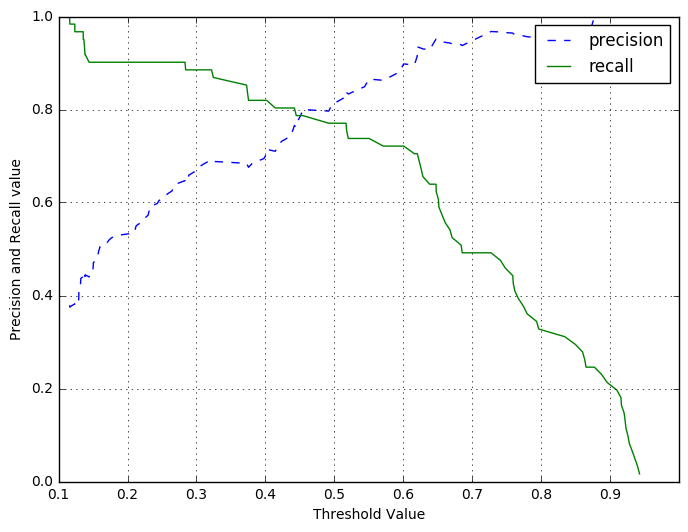

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    #threshold ndarray와 그에 따른 정밀도, 재현율 ndarray 추출
    precision, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    #X축은 threshold, y축은 정밀도, 재현율 각각 plot -> 정밀도는 점선으로
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    #thresgold값 X축 scale을 0.1단위로
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    #x축, y축 label과 legend, grid설정
    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall value')
    plt.legend();plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

F1 score : precision + recall

In [22]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('f1 score : {0:.4f}'.format(f1))

f1 score : 0.7966


In [23]:
#threshold 변경시키면서 F1 score포함 평가지표 구하기
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    #f1 score 추가
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4 , 0.45 , 0.50 , 0.55 , 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
오차행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, F1:0.7576
임곗값: 0.45
오차행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, F1:0.7869
임곗값: 0.5
오차행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, F1:0.7966
임곗값: 0.55
오차행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, F1:0.7965
임곗값: 0.6
오차행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, F1:0.8000


## ROC Curve , AUC

In [24]:
#roc curve() :: 파라미터 y_true, y_score :: fpr, tpr, thresholds 각각 array로 반환
from sklearn.metrics import roc_curve

# 레이블 값이 1일때 예측확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

In [25]:
#반환된 임곗값 배열에서 샘플로 데이터 추출. 5step으로
#thresholds[0]은 max(예측확률)+1로 임의설정된다.이를 제외하기 위해 np.arange를 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)

print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값:', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임곗값 따른 FPR, TPR
print('샘플 임곗값 별 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임곗값 별 TPR:', np.round(tprs[thr_index], 3))


샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값: [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값 별 FPR: [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값 별 TPR: [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


In [26]:
thresholds.shape

(48,)

In [27]:
print('max predict_proba: ', np.max(pred_proba_class1))
print('thresholds[0]: ', thresholds[0])

max predict_proba:  0.9432627932179585
thresholds[0]:  1.9432627932179585


In [28]:
import sys; sys.setrecursionlimit(10000)
#maximum recursion depth exceeded 라는 error가 나서 해결하기 위해 넣어줌
#재귀한도 늘려줌

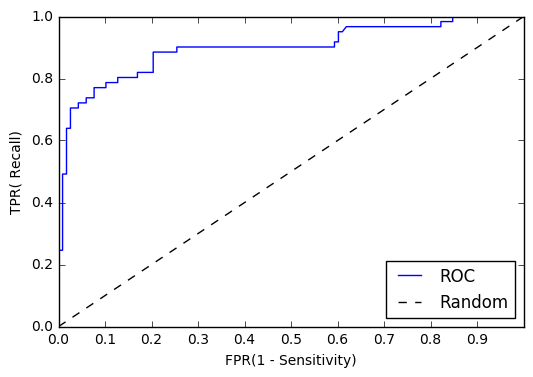

In [36]:
def roc_curve_plot(y_test, pred_proba_c1):
    #임계값따른FPR, TPR값 반환받기
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    #plot곡선으로 표현
    plt.plot(fprs, tprs, label='ROC') #fpr:X,tpr:Y, label명 :: roc곡선
    #가운데 대각선 직선
    plt.plot([0, 1], [0, 1], 'k--', label='Random') #x범위, y범위, 'k--':블랙점선, label명
    
    #FPR X 축의 Scale을 0.1단위 변경, X, Y축명 설정 등등
    start, end = plt.xlim() #x축 시작점 끝점을 start와 end에 각각 지정
    plt.xticks(np.round(np.arange(start, end, 0.1), 2)) #x축 눈금조정
    plt.xlim(0,1);plt.ylim(0,1) #x,y축 범위limit
    plt.xlabel('FPR(1 - Sensitivity)'); plt.ylabel('TPR( Recall)') #X, Y축 레이블
    plt.legend(loc=4) #범례표시
    plt.show()
    

roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [37]:
#AUC값
from sklearn.metrics import roc_auc_score
pred_proba = lr_clf.predict_proba(X_test)[:,1] #positive일 확률
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값:{0:.4f}'.format(roc_score))

ROC AUC 값:0.8987


In [39]:
def get_clf_eval(y_test, pred=None, pred_proba=None): #default값을None으로줌
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))